# ### Advanced Machine Learning

# Unsupervised Learning - Clustering and Mixture Models


# HW #3: Unsupervised ML 


In [4]:
student1Name="Alexander Kruglyak"
student1ID="323637736"


student2Name="Sofya Zubtsovsky"
student2ID="337839112"

## MNIST dataset

We saw this dataset in a previous class exercise. The MNIST handwritten digit dataset consists of images of handwritten digits, together with labels indicating which digit is in each image. 

Becaue both the features and the labels are present in this dataset (and labels for large datasets are generally difficult/expensive to obtain), this dataset is frequently used as a benchmark to compare various methods. 
For example, [this webpage](http://yann.lecun.com/exdb/mnist/) describes a variety of different classification results on MNIST (Note, the tests on this website are for a larger and higher resolution dataset than we'll use.) To see a comparison of classification methods implemented in scikit-learn on the MNIST dataset, see 
[this page](http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html).
The MNIST dataset is also a frequently used for benchmarking clustering algorithms and because it has labels, we can evaluate the homogeneity or purity of the clusters. 

There are several versions of the dataset. We'll use the one that is built-in to scikit-learn, described [here](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). 

* Classes: 10  
* Samples per class: $\approx$180
* Samples total: 1797
* Dimensionality: 64 (8 pixels by 8 pixels)
* Features: integers 0-16

Here are some examples of the images. Note that the digits have been size-normalized and centered in a fixed-size ($8\times8$ pixels) image.

<img src="http://scikit-learn.org/stable/_images/sphx_glr_plot_digits_classification_001.png" width="500">

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.datasets import make_blobs, make_moons, load_iris, load_digits
from sklearn.cluster import *
# from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import kneighbors_graph, DistanceMetric
from sklearn.metrics import homogeneity_score, homogeneity_completeness_v_measure
from sklearn.preprocessing import scale
from sklearn.mixture import GaussianMixture

from time import time

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Create color maps
cmap = ListedColormap(["Red","Green","Blue"])
# cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8","#ffff33","#4daf4a","#ff7f00"])
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

<class 'numpy.ndarray'>
n_digits: 10, n_samples 1797, n_features 64


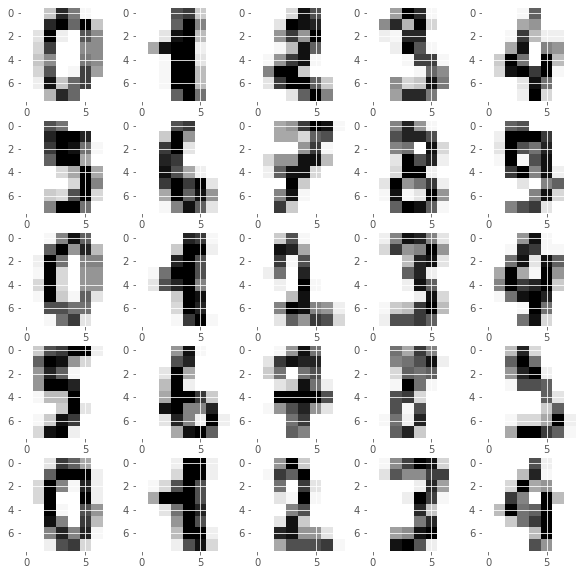

In [59]:
digits = load_digits()
X = digits.data
y = digits.target
print(type(X))

n_samples, n_features = X.shape
n_digits = len(np.unique(digits.target))
print("n_digits: %d, n_samples %d, n_features %d" % (n_digits, n_samples, n_features))

plt.figure(figsize= (10, 10))
for ii in np.arange(25):
    plt.subplot(5, 5, ii+1)
    plt.imshow(np.reshape(X[ii,:],(8,8)), cmap='Greys',interpolation='none')
plt.show()

## MNIST: visualization
**1:** Use PCA and T-SNE methods to project a 2D visualization of the dataset 

(1797, 2)


Text(0, 0.5, 'Y')

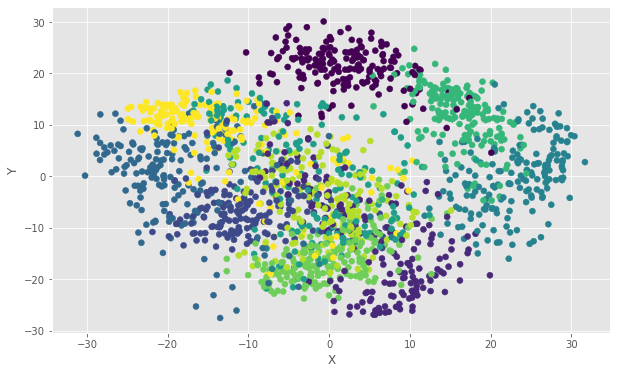

In [60]:
#### PCA ####
from sklearn.decomposition import PCA

N_COMPONENTS = 2

pca = PCA(n_components=N_COMPONENTS)
X_pca = pca.fit_transform(X)
print(X_pca.shape)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.xlabel("X")
plt.ylabel("Y")

(1797, 2)


Text(0, 0.5, 'Y')

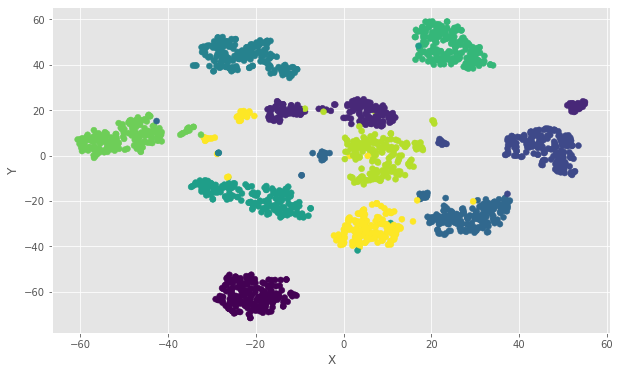

In [61]:
#### TSNE ####
from sklearn.manifold import TSNE

tsne = TSNE(n_components=N_COMPONENTS)
X_tsne = tsne.fit_transform(X)
print(X_tsne.shape)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
plt.xlabel("X")
plt.ylabel("Y")

## MNIST:  clustering
**1:** Use k-means method to cluster the dataset and compute the homogeneity score for the clustering. 

In [62]:
from sklearn.cluster import KMeans

homogenity_scores_df = pd.DataFrame(dtype=float)
pd.options.display.float_format = '{:.20f}'.format

kmeanclusters = n_digits
km = KMeans(n_clusters=kmeanclusters)
km.fit(X)
homogenity_scores_df.loc['Kmeans', 'Score'] = homogeneity_score(y,km.labels_)
homogenity_scores_df

,Score
Kmeans,0.73467757417528589681



**2:** Use a hierarchical clustering method to cluster the dataset. Again compute the homogeneity. Did it change?


In [63]:
for linkage in ['ward', 'complete', 'average', 'single']:
    clustering = AgglomerativeClustering(n_clusters=n_digits, linkage=linkage)
    clustering.fit_predict(X)
    homogenity_scores_df.loc[linkage, 'Score'] = homogeneity_score(y,clustering.labels_)
homogenity_scores_df

,Score
Kmeans,0.73467757417528589681
ward,0.85751287195047232181
complete,0.59054938825383584966
average,0.65539273883407156429
single,0.00505635651691705226


**3.** Use DBScan to cluster the dataset. A problem you will face is choosing $\epsilon$. You can use the DistanceMetric function to get a sense of typical distances between points.  Again compute the homogeneity.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of distances between points')

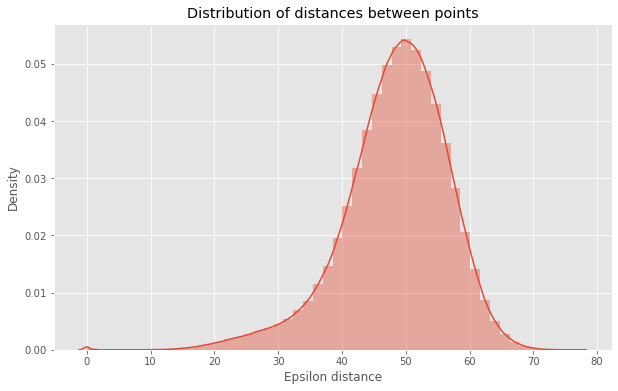

In [64]:
dist = DistanceMetric.get_metric('euclidean')
distances = dist.pairwise(X)
sns.distplot(distances, hist=True, kde=True)
plt.xlabel('Epsilon distance')
plt.title("Distribution of distances between points")

In [65]:
dbscan = DBSCAN()
dbscan.fit_predict(X)
homogenity_scores_df.loc['DBSCAN default', 'Score'] = homogeneity_score(y,dbscan.labels_)
homogenity_scores_df

,Score
Kmeans,0.73467757417528589681
ward,0.85751287195047232181
complete,0.59054938825383584966
average,0.65539273883407156429
single,0.00505635651691705226
DBSCAN default,0.00000000000000003616


In [66]:
# we define epsilon ranges according to distance metric distribution
eps = np.arange(5,30,5)
min_samples = np.arange(1,10,1)
for e in eps:
    for m in min_samples: 
        dbscan = DBSCAN(eps=e, min_samples=m)
        dbscan.fit_predict(X)
        homogenity_scores_df.loc['DBSCAN epsilon ' + str(e) + " sample " + str(m), 'Score'] = homogeneity_score(y,dbscan.labels_)
homogenity_scores_df

,Score
Kmeans,0.73467757417528589681
ward,0.85751287195047232181
complete,0.59054938825383584966
average,0.65539273883407156429
single,0.00505635651691705226
DBSCAN default,0.00000000000000003616
DBSCAN epsilon 5 sample 1,1.00000000000000022204
DBSCAN epsilon 5 sample 2,0.00000000000000003616
DBSCAN epsilon 5 sample 3,0.00000000000000003616
DBSCAN epsilon 5 sample 4,0.00000000000000003616


**4.** Use Gausian Mixture Models to cluster the dataset.  Again compute the homogeneity.

In [67]:
gmm = GaussianMixture(n_components=n_digits)
y_pred = gmm.fit_predict(X)
homogenity_scores_df.loc['GaussianMixture', 'Score'] = homogeneity_score(y,y_pred)
homogenity_scores_df

,Score
Kmeans,0.73467757417528589681
ward,0.85751287195047232181
complete,0.59054938825383584966
average,0.65539273883407156429
single,0.00505635651691705226
DBSCAN default,0.00000000000000003616
DBSCAN epsilon 5 sample 1,1.00000000000000022204
DBSCAN epsilon 5 sample 2,0.00000000000000003616
DBSCAN epsilon 5 sample 3,0.00000000000000003616
DBSCAN epsilon 5 sample 4,0.00000000000000003616


In [68]:
homogenity_scores_df.sort_values(by="Score", inplace=True)
homogenity_scores_df.tail(10)

,Score
Kmeans,0.73467757417528589681
DBSCAN epsilon 20 sample 5,0.75149259380903810079
GaussianMixture,0.75837318371059725397
DBSCAN epsilon 20 sample 2,0.76304291655812872541
DBSCAN epsilon 20 sample 4,0.78127882164288686706
ward,0.85751287195047232181
DBSCAN epsilon 20 sample 1,0.89747895872786298543
DBSCAN epsilon 5 sample 1,1.00000000000000022204
DBSCAN epsilon 15 sample 1,1.00000000000000044409
DBSCAN epsilon 10 sample 1,1.00000000000000044409


**5.** Take a look at the clustering methods and options for various methods on the [scikit-learn page](http://scikit-learn.org/stable/modules/clustering.html). By modifying the following code, try to find the clustering method with the largest homogeneity score for this dataset. 

In [69]:
methods = {
    'AffinityPropagation': AffinityPropagation(),
    'MeanShift': MeanShift(n_jobs=-1),
    'OPTICS':OPTICS(n_jobs=-1),
    'Birch':Birch(n_clusters=n_digits),
    'SpectralClustering':SpectralClustering(n_clusters=n_digits,n_jobs=-1)
}

In [70]:
def compare_method(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 25s   %.2fs     %.3f ' % (name, (time() - t0), metrics.homogeneity_score(y, estimator.labels_)))
    
for name, method in methods.items():
    method.fit(X)
    homogenity_scores_df.loc[name, 'Score'] = homogeneity_score(y,method.labels_)
#     compare_method(estimator=method, name=name, data=X)
homogenity_scores_df

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


,Score
DBSCAN epsilon 10 sample 6,0.00000000000000003616
DBSCAN epsilon 10 sample 5,0.00000000000000003616
DBSCAN epsilon 5 sample 9,0.00000000000000003616
DBSCAN epsilon 5 sample 8,0.00000000000000003616
DBSCAN epsilon 5 sample 7,0.00000000000000003616
DBSCAN epsilon 5 sample 6,0.00000000000000003616
DBSCAN epsilon 5 sample 5,0.00000000000000003616
DBSCAN epsilon 5 sample 4,0.00000000000000003616
DBSCAN epsilon 5 sample 3,0.00000000000000003616
DBSCAN epsilon 5 sample 2,0.00000000000000003616


In [71]:
homogenity_scores_df.sort_values(by="Score", inplace=True)
homogenity_scores_df.tail(10)

,Score
GaussianMixture,0.75837318371059725397
DBSCAN epsilon 20 sample 2,0.76304291655812872541
DBSCAN epsilon 20 sample 4,0.78127882164288686706
ward,0.85751287195047232181
Birch,0.85751287195047232181
DBSCAN epsilon 20 sample 1,0.89747895872786298543
AffinityPropagation,0.95890732178841164846
DBSCAN epsilon 5 sample 1,1.00000000000000022204
DBSCAN epsilon 15 sample 1,1.00000000000000044409
DBSCAN epsilon 10 sample 1,1.00000000000000044409


We can see that for our dataset we have DBSCAN with 3 different parameters that can provide perfect labeling (homogenity score of 1)